# Problem 1

Let us define M = mean $\left(\sum_{ij} level_{ij}\right)$

We can define set A such that $level_{ij} - M > 0$ and set B such that $level_{ij} - M \leq 0$
k, q are the number of elements in A and B respectively.
Than we can write our objective $$ min \sum_{kq} f_{kq} c_{kq} $$
S.T.
$$ \sum_{k} c_{kq} = a_k $$ for every q.
$$ \sum_{q} c_{kq} = b_q $$ for every k.
$$ c_{kq} \geq 0 $$
$$ c_{kq} \leq d $$

In [10]:
import numpy as np
import cvxpy
    
def euclidean_distance(x0, y0, x1, y1):
    return np.sqrt((x0 - x1) ** 2 + (y0 - y1) ** 2)


heights = np.array([[5, 5, 10, 10, 10],
                    [5, 5, 10, 20, 10],
                    [0, 5, 5, 10, 5],
                    [0, 0, 0, 5, 0]],dtype = np.int)
mean = np.mean(heights, dtype = np.int)
donors = []
recipients = []

for i in range(heights.shape[0]):
    for j in range(heights.shape[1]):
        if heights[i, j] > mean:
            donors.append((heights[i, j] - mean, i, j))
        else:
            recipients.append((mean - heights[i, j], i, j))

f = np.zeros((len(donors), len(recipients)))
d = np.zeros(len(donors))
b = np.zeros(len(recipients))

for i in range(len(recipients)):
    b[i] = recipients[i][0]

for i in range(len(donors)):
    d[i] = donors[i][0]
    
    for j in range(len(recipients)):
        f[i, j] = euclidean_distance(donors[i][1], donors[i][2], recipients[j][1], recipients[j][2])

c = cvxpy.Variable(len(donors), len(recipients))

constraints = []

for i in range(len(donors)):
    constraints.append(cvxpy.sum_entries(c[i:(i + 1), :]) == d[i])
    
for i in range(len(recipients)):
    constraints.append(cvxpy.sum_entries(c[:, i:(i + 1)]) == b[i])
    
for i in range(len(donors)):
    for j in range(len(recipients)):
        constraints.append(c[i, j] >= 0)
        constraints.append(c[i, j] <= d[i])

# Form objective.
objective = cvxpy.Minimize(cvxpy.trace(c * f.T))

# Form and solve problem.
solution = cvxpy.Problem(objective, constraints)
solution.solve(solver = 'GUROBI')

print('Optimal value is: {0}'.format(solution.value))
print('c = \n{0}'.format(c.value))

Optimal value is: 95.4910638367
c = 
[[ 1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  3.]
 [ 0.  0.  0.  0.  2.  1.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  5.  6.  2.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  3.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.]]


# Problem 2

In [5]:
import numpy as np
import numpy.matlib
import cvxpy
import copy

np.random.seed(1)

C = 20 # number of clients
clients = np.random.rand(2,C) #client positions
F = 15 # number of facilities
facilities = np.random.rand(2,F)

capacities = np.ones((F,)) * 4 #maximum number of clients per facility

dx = np.matlib.repmat(clients[0,:],F,1) - np.matlib.repmat(facilities[0,:],C,1).transpose()
dy = np.matlib.repmat(clients[1,:],F,1) - np.matlib.repmat(facilities[1,:],C,1).transpose()

assignment_costs = 3 * (dx * dx + dy * dy) #the assignment cost is the distance squared

opening_costs = np.ones((F,))

def get_lower_bound(opened = []):
    assignments = cvxpy.Variable(F, C)
    openings = cvxpy.Variable(F)

    constraints = []

    for index, is_opened in opened:
        constraints.append(openings[index] == is_opened)
        
    for i in range(F):
        constraints.append(cvxpy.sum_entries(assignments[i, :]) <= capacities[i] * openings[i])

        for j in range(C):
            constraints.append(assignments[i, j] <= 1)
            constraints.append(assignments[i, j] >= 0)

    for i in range(C):
        constraints.append(cvxpy.sum_entries(assignments[:, i]) == 1)
        constraints.append(assignments[:, i] <= openings)

    constraints.append(openings <= 1)
    constraints.append(openings >= 0)

    objective = cvxpy.Minimize(cvxpy.trace(assignments * assignment_costs.T) + opening_costs * openings)

    solution = cvxpy.Problem(objective, constraints)
    solution.solve(solver = 'GUROBI')
    
    return (solution.value, assignments.value, openings.value)

def is_integer(openings):
    for opening in openings:
        if opening != int(opening):
            return False
        
    return True

def branch_facilities(openings):
    fractionality = np.array(openings - openings.astype(np.int)).transpose()[0]
    
    if fractionality.max() == 0:
        return -1
    
    return np.where(fractionality == fractionality.max())[0][0]

def branch_and_bound():
    _, _, openings = get_lower_bound()
    L = [(openings, [])]
    best_solution = None
    incumbent_value = np.inf
    
    while L:
        openings, constraints = L.pop()

        facility = branch_facilities(openings)
        
        if facility == -1:
            continue
        
        for j in range(2):
            tmp_constraints = copy.deepcopy(constraints)
            
            try:
                lower_bound, assignments, openings = get_lower_bound(tmp_constraints + [(facility, j)])
            except cvxpy.SolverError:
                lover_bound = np.inf

            if lower_bound >= incumbent_value:
                continue

            if is_integer(openings):
                incumbent_value = lower_bound
                best_solution = (lower_bound, assignments, openings)
            else:
                tmp_constraints.append((facility, j))
                L.append((openings, tmp_constraints))
         
        
    return best_solution

In [6]:
best_solution = branch_and_bound()

In [8]:
print 'The optimal objective is {0}'.format(g[0])
g[1]

The optimal objective is 7.57111292313


matrix([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,
          0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  1.,  0.,  1.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,

# Problem 3

We can formulate the problem as:

$$\max \sum_{ij} c_{ij} f_{ij} $$
S.T.
for every i $$\sum_{j} c_{ij} = 1$$
for every j $$\sum_{j} c_{ij} = 1$$
for every i,j $$c_{ij} \leq \sum_{j} c_{ij}$$
for every i,j $$c_{ij} \leq \sum_{i} c_{ij}$$
$$c_{ij} = {0, 1}$$

Where $f_{ij}$ student i preference to live with j neighbour, that is symmetric ($f_{ij} = f_{ji}$).

Optimal value is: 17.182424876
c = 
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.

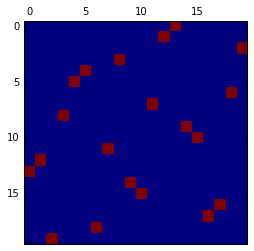

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy

%matplotlib inline

n = 20
m = 10

np.random.seed(1)

preferences = np.random.random((n, n))
preferences = (preferences + preferences.T) / 2

C = cvxpy.Bool(n, n)

constraints = []

for i in range(n):
    constraints.append(cvxpy.sum_entries(C[i, :]) == 1)
    constraints.append(cvxpy.sum_entries(C[:, i]) == 1)
    
    for j in range(n):
        constraints.append(C[i, j] <= cvxpy.sum_entries(C[:, j]))
        constraints.append(C[i, j] <= cvxpy.sum_entries(C[i, :]))

objective = cvxpy.Maximize(cvxpy.trace(C * preferences.T))

# Form and solve problem.
solution = cvxpy.Problem(objective, constraints)
solution.solve(solver = 'GUROBI')

print('Optimal value is: {0}'.format(solution.value))
print('c = \n{0}'.format(C.value))

plt.matshow(C.value)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy

%matplotlib inline

n = 20
m = 10

np.random.seed(1)

preferences = np.random.random((n, n))
preferences = (preferences + preferences.T) / 2
np.fill_diagonal(preferences, -100)

C = cvxpy.Variable(n, n)

constraints = []

for i in range(n):
    constraints.append(cvxpy.sum_entries(C[i:i + 1, :]) == 1)
    constraints.append(cvxpy.sum_entries(C[:, i:i + 1]) == 1)
    
    for j in range(n):
        constraints.append(C[i, j] >= 0)
        constraints.append(C[i, j] <= 1)
        constraints.append(C[i, j] <= cvxpy.sum_entries(C[:, j:j+1]))
        constraints.append(C[i, j] <= cvxpy.sum_entries(C[i:i+1, :]))

objective = cvxpy.Maximize(cvxpy.trace(C * preferences.T))

# Form and solve problem.
solution = cvxpy.Problem(objective, constraints)
solution.solve()

print('Optimal value is: {0}'.format(solution.value))
print('c = \n{0}'.format(C.value))
plt.matshow(C.value)
plt.matshow(preferences)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy

%matplotlib inline

n = 20
m = 10

np.random.seed(1)

preferences = np.random.random((n, n))
preferences = (preferences + preferences.T) / 2
np.fill_diagonal(preferences, -100)

C = cvxpy.Variable(n, n)

constraints = []

for i in range(n):
    constraints.append(cvxpy.sum_entries(C[i:i + 1, :]) == 1)
    constraints.append(cvxpy.sum_entries(C[:, i:i + 1]) == 1)
    
    for j in range(n):
        constraints.append(C[i, j] >= 0)
        constraints.append(C[i, j] <= 1)
        constraints.append(C[i, j] <= cvxpy.sum_entries(C[:, j:j+1]))
        constraints.append(C[i, j] <= cvxpy.sum_entries(C[i:i+1, :]))
        
objective = cvxpy.Maximize(cvxpy.trace(C * preferences.T))

# Form and solve problem.
solution = cvxpy.Problem(objective, constraints)
solution.solve()

print('Optimal value is: {0}'.format(solution.value))
print('c = \n{0}'.format(C.value))
plt.matshow(C.value)